 # Skincare Recommendation System using Collaborative Filtering (Matrix Factorization)

<h2>Introduction</h2>

Have you ever imagine how Netflix give you recommendation for movies you have never watch before? <br>
<div style="text-align:justify">If you're familiar with machine learning, you can find the answer. Yappps.. that's right. The answer is "Recommendation System".
Recommendation system or recommender system is subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. Recommendation system aims to telling us which movies to watch (Netflix), which product to buy (Amazone), or which songs to listen (Spotify) based on our historical data.<br></div>
<div style="text-align:justify"><b>Collaborative filtering</b> is one of basic models for recommendation system which are based on assumption that people like things similar to other things they like, or things that are liked by other people which have similar taste with them.<br></div>
The ilustration given below :

<img src="New Project.png" width="600" />

<div style="text-align:justify">From the ilustration above, information given that Kiki (girl with black cat) likes to buy apple, banana, and watermelon. While Satsuki (girl with yellow shirt) likes to buy apple and banana. They have similar taste in apple and banana, so we can recommend Satsuki to buy watermelon.<br></div>
In <b>collaborative filtering</b> method there are two approaches which can be implemented :<br>
<b>1. Memory-based approach: </b>create recommendation system by calculated closest users or items using cosine similarity or pearson correlation coefficients.<br>
<b>2. Model-based approach: </b>create recommendation system by given predict user's rating value of unrated items.<br>
<br>
<div style="text-align:justify">In this notebook, I will create simply recommender system to recommend skincare product to the customers which have never buy before. I'll predict the unrated items using Singular Value Decomposition (SVD) of <b>Matrix Factorization</b> algorithm. The data used comes from scraping result in Femaledaily Website. Data contains information about review product given by customers. There are several attribut inside, for more details, let's check it out!</div>

<h2>Data Preparation</h2>

<h4>Import library</h4>

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns

<h4>Read the data</h4>

In [2]:
data = pd.read_csv("data_input/Female Daily Skincare Review Final.csv")

<h4>Check and drop missing values</h4>

In [3]:
data.isna().sum()

Reviewer       2
Recommend      0
Stars          0
Date           0
Product        0
Category       0
Date Scrape    0
Url            0
dtype: int64

In [4]:
data = data.dropna()

<h4>Check and drop duplicated values</h4>

In [5]:
data.duplicated().sum()
data.drop_duplicates(keep = "first", inplace = True)

<h4>Filter the data</h4><br>
In this section I will do filtering on the data where customer only rated the product once. Since those data having less information in recommendation system.

In [6]:
id_count = pd.crosstab(index=data.Reviewer,columns='count').sort_values(by='count',ascending=True)

In [7]:
name_r = id_count[id_count['count']>1]
name_u = name_r.index.to_list()
data = data[data.Reviewer.isin(name_u)]
data.to_csv('femdaily.csv',index=False,header=True)

<h4>Drop unused columns</h4>

In [12]:
data = pd.read_csv("femdaily.csv")
data.drop_duplicates(keep = "first", inplace = True)
data.drop(['Recommend','Date','Date Scrape','Url','Category'], axis=1, inplace=True)
data.rename(columns={'Reviewer':'reviewer','Product':'product','Stars':'rating'}, inplace=True)
data = (data[~(data['reviewer'] == ' ')])

In [13]:
data

reviewer  rating                 product
0                Ayuika       3          Perfect 3D Gel
1          yustinalupit       4          Perfect 3D Gel
2             evikdanny       3          Perfect 3D Gel
3          daniskhoirun       3          Perfect 3D Gel
4             hulahup19       5          Perfect 3D Gel
...                 ...     ...                     ...
137295          steph91       4  Ultra Rapid Action Pad
137296  farishaalamsyah       1  Ultra Rapid Action Pad
137297    imeldanababan       4  Ultra Rapid Action Pad
137298      princessvie       3  Ultra Rapid Action Pad
137299            nucky       2  Ultra Rapid Action Pad

[137292 rows x 3 columns]

<h2>Data Exploration</h2>

Since in the next step (modelling) we will define and create matrix based on Product X User, so we need to understanding about size of both unique product and user.

<h4>Number of uniq product</h4>

In [14]:
uniq_product = data['product'].nunique()
print("Number of uniq product :",uniq_product)

Number of uniq product : 3297


Here above, product have 3297 unique number, this number will become number of columns matrix in modelling step.

<h4>Number of uniq users</h4>

In [15]:
uniq_reviewer = data['reviewer'].nunique()
print("Number of uniq reviewer :",uniq_reviewer)

Number of uniq reviewer : 22359


Here above, user have 22359 unique number, this number will become number of rows matrix in modelling step.

<h4>Distribution rating given by users</h4>

(array([2.0000e+00, 0.0000e+00, 5.1450e+03, 0.0000e+00, 1.1718e+04,
        0.0000e+00, 2.6710e+04, 0.0000e+00, 4.2248e+04, 5.1469e+04]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

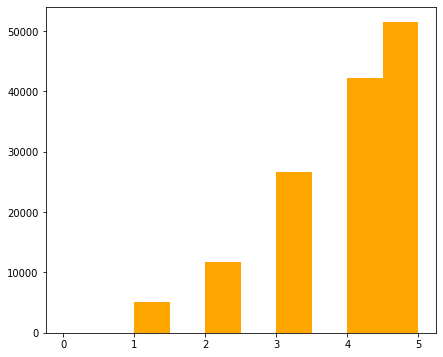

In [16]:
plt.subplots(figsize = (7,6))
plt.hist(data['rating'],color="orange")

From the visualization above, bar plot shown that users frequently give rating in 5 or 4, which mean that they are satisfied with the product.

<h2>Build Recommendation System</h2>

<h3>Matrix Factorization</h3>

<div style="text-align:justify">If you see the pivot matrix below, you will find that pivot matrix have so many zero value (missing value). Why did it happen? It can be happen because not every user give a rating in a every product, this condition called <b>sparse matrix.</b>Sparse matrix is limitation in collaborative filtering models, because sparse matrix gives bias information in our recommender system. There will be popularity bias in the recommendation given by the system to user, system will give recommends the product with the most interactions without any personalization.<br></div>
<div style="text-align:justify"><b>Matrix Factorization</b> is one way to handle those issue. Matrix factorization will breaking down of one matrix into a product of multiple matrices and give predictive rating in sparse matrix. Basic idea from matrix factorization is that attitudes or preferences of a user can be determined by a small number of hidden factors.<br></div>
Illustration given below:

<img src="matrix.JPG" width="600" />

<div style="text-align:justify">Intuitively, we can understand hidden factors for items and users from illustration above. Say that U is low dimensional matrix for Users features and V is low dimensional matrix for Product features. Every matrix values represent different characteristics about the users and the product. For e.g I have 3 features in Product matrix <i>(i) what kind categories of the product? (ii) Does the product contains dangerous addictive substance? (iii)How the product give impact in our skin? </i> Likewise, in Users matrix might represent <i>(i)how sensitive the user's skin into the product substances? (ii)Does the user like "X" category product, an so on</i>. We can get the predictive ratings by calculate the dot product between matrix U and matrix V.</div>

<h3>Singular Value Decomposition (SVD)</h3>


<div style="text-align:justify"><b>Singular Value Decomposition</b> is one of type Matrix Factorization. SVD algorithm will decomposes a matrix R into the best lower rank approximation of the original matrix R. Matematically SVD produce by the formula below :</div>

<img src="svd.JPG" width="150" />

<div style="text-align:justify">where U and V are orthogonal matrix with orthonormal eigenvectors and $\sum$ is the diagonal matrix of singular values (essentially weights). The matrix can be factorized as :</div>

<img src="matrix_.jpg" width="550" />

We can arrange eigenvectors in different orders to produce U and V.

<h4>Implementation Recommender System in Python Code</h4>

<h4>a. Create matrix pivot</h4><br>
Create matrix pivot where the vertical value is users name, horizontal value is product name, and the value inside matrix is rating given by users.

In [21]:
matrix_pivot = pd.pivot_table(data,values='rating',index='reviewer',columns='product').fillna(0)
matrix_pivot.head()

product       0,2 mm Therapy Air Mask Sheet  ...  “B” oil
reviewer                                     ...         
01lely                                  0.0  ...      0.0
01putrisalma                            0.0  ...      0.0
01sary                                  0.0  ...      0.0
123hayoapa                              0.0  ...      0.0
15ayusafitri                            0.0  ...      0.0

[5 rows x 3297 columns]

<h4>b. Normalize rating values</h4><br>
Why we do need to normalize the rating?<br>
<div style="text-align:justify">Because it starts with the fact that people rate often on very different scales. Say that Kiki and Satsuki use a product B, and Kiki gives rating value 5 on that product, because Satsuki has a high standart she only gives 3 on that product. Here is, the 5 from Kiki is 3 from Satsuki. To make the model better is, we can increase the efficiency of this algorithm if we normalize user’s rating by substract rating value given by user in each product with mean rating in each product.</div>

In [0]:
matrix_pivot_ = matrix_pivot.values
user_ratings_mean = np.mean(matrix_pivot_, axis = 1)
user_rating = matrix_pivot_ - user_ratings_mean.reshape(-1,1)


<h4>c. Singular Value Decomposition (SVD)</h4><br>
Create matrix U and Vt using library scipy.

In [0]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(user_rating, k = 50)

In [0]:
sigma = np.diag(sigma)

<h4>d. Create predictive rating</h4><br>
After we get the value from decomposition matrix above, we can create product ratings predictions for every user. 

In [0]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

And, here below matrix is result of predictive rating from each user in each product. 

In [26]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = matrix_pivot.columns, index=matrix_pivot.index)
preds_df

product       0,2 mm Therapy Air Mask Sheet  ...       “B” oil
reviewer                                     ...              
01lely                            -0.033156  ... -4.931434e-03
01putrisalma                       0.010625  ...  7.925640e-04
01sary                             0.001551  ... -1.701105e-03
123hayoapa                         0.015527  ...  5.204980e-07
15ayusafitri                       0.003480  ...  1.148843e-03
...                                     ...  ...           ...
zvnazole                          -0.005587  ...  3.074178e-03
zyshalu                           -0.013294  ...  2.718208e-04
zzarahs                           -0.003167  ...  4.559316e-03
zzfatimah                          0.002338  ...  1.161053e-02
zzulia                            -0.010500  ... -1.232599e-03

[22359 rows x 3297 columns]

<h4>e. Create recommendation</h4><br>
In this final step we will create recommendation product. I'll return the product with the 5 highest predicted rating that the user hasn’t already rated. 

In [0]:
 def recommend_product(predictions_df, user, data_,num_recommendations):
   
    user_row_number = user
    sorted_user_predictions = preds_df.loc[user_row_number].sort_values(ascending=False)

    user_data = data_[data_.reviewer == (user)]
    user_full = user_data


    print('User {0} has already rated {1} product'.format(user, user_full.shape[0]))

    a = data.drop_duplicates(subset='product', keep='last')
    recommendations = (a[~a['product'].isin(user_full['product'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'product',
               right_on = 'product').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

Input the user id to whom you want recommend the product.

In [28]:
user = str(input("Enter the user id to whom you want to recommend : "))
already_rated, predictions = recommend_product(preds_df, user, data,5)

Enter the user id to whom you want to recommend : zzulia
User zzulia has already rated 3 product


Result below shown that "zzulia" already rate 3 product. Twice for Facial Mask with different rating in each product, and once for Pembersih Two In One Bengkoang Whitening.

In [29]:
already_rated

reviewer  rating                                   product
70013    zzulia       3                               Facial Mask
88179    zzulia       2                               Facial Mask
115840   zzulia       5  Pembersih Two In One Bengkoang Whitening

<div style="text-align:justify">And, here below 5 highest predicted rating from user id "zzulia". The recommendation system suggest "zzulia" to buy Prominent Essence Facial Mask, Facial Mask Bedak Dingin, Oil Control Mask, White Aqua Serum Sheet Mask, and Essential Vitamin. Suggested products are dominated with "Mask" product, because from historical data above "zzulia" already rate 2 product with category "Mask.</div>

In [0]:
prod_pred = predictions['product']

In [31]:
prod_pred

2040    Prominent Essence Facial Mask
2225         Facial Mask Bedak Dingin
1988                 Oil Control Mask
2000      White Aqua Serum Sheet Mask
1661                Essential Vitamin
Name: product, dtype: object

<h2>Conclusion</h2>

From the result above, we can conclude that:<br>
1. Based on recommendation system above, Femaledaily website can provide product recommendation in the main dashboard when targeted users access the website.<br>
2. Low dimensional matrix in Matrix factorization tried to capture the underlying features or hidden factors from the users and items.<br>
3. This model is the right choice if you have many sparcity data.<br>
